In [151]:
'''Sales and Customer data pipeline with aggregations and visualizations'''

#All the necessary imports
import pandas as pd
import requests
import datetime
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10), dpi=100)
from sqlalchemy import create_engine

#Vars declaration
#**Note API Tokens should be hidden
RETAIL_COMPANY_DB = create_engine("sqlite:///db/retail_company.db")  # pass your db url
USERS_URL = "https://jsonplaceholder.typicode.com/users"
WEATHER_API_KEY = "90040f64fbc913fdfa0513197b181600"
WEATHER_BASE_URL = "http://api.openweathermap.org/data/2.5/weather?"


#Source_1 : Customer data
response = requests.get(USERS_URL)
response_json = response.json()
user_df=pd.json_normalize(response_json)
user_df=user_df[['id','name','username','email','address.geo.lat','address.geo.lng']]
user_df.rename(columns={'address.geo.lat':'lat','address.geo.lng':'lng'}, inplace = True)
user_df.head()

,id,name,username,email,lat,lng
0,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,-43.9509,-34.4618
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,-68.6102,-47.0653
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,29.4572,-164.2990
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,-31.8129,62.5342


<Figure size 1000x1000 with 0 Axes>

In [152]:
#Source_2 : Sales data
sales_df=pd.read_csv('source_data/random_data.csv')
sales_df.head()

,order_id,customer_id,product_id,quantity,price,order_date
0,2334,5,40,3,35.60,2022-06-21
1,6228,8,13,7,36.52,2023-03-08
2,7784,9,44,4,46.56,2023-04-22
3,6588,5,26,1,15.87,2022-10-23
4,5910,8,32,10,77.00,2022-10-05


In [153]:
#Join Sales-Customers
merged_df=pd.merge(user_df, sales_df, left_on='id', right_on='customer_id', how='inner')
merged_df.head()

,id,name,username,email,lat,lng,order_id,customer_id,product_id,quantity,price,order_date
0,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,4018,1,20,4,36.85,2022-06-18
1,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,7231,1,38,7,95.54,2023-05-31
2,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,8994,1,41,2,94.41,2022-07-13
3,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,3361,1,26,8,82.75,2023-05-04
4,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,3578,1,10,3,73.61,2023-04-24


In [154]:
#Source_3 : Weather data
def fetch_weather(row):
    complete_url = WEATHER_BASE_URL + "appid=" + WEATHER_API_KEY + "&lat=" + row['lat'] + "&lon=" + row.lng + "&dt=" + str(row.order_date_unix)
    response = requests.get(complete_url)
    return response.json()

In [155]:
merged_df['order_date']=pd.to_datetime(merged_df['order_date'])
merged_df['order_date_unix']=merged_df['order_date'].apply(lambda x : int((x-datetime.datetime(1970,1,1)).total_seconds()))
merged_df['weather_json']=merged_df.apply(fetch_weather, axis=1)
merged_df.head()

,id,name,username,email,lat,lng,order_id,customer_id,product_id,quantity,price,order_date,order_date_unix,weather_json
0,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,4018,1,20,4,36.85,2022-06-18,1655510400,"{'coord': {'lon': 81.1496, 'lat': -37.3159}, '..."
1,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,7231,1,38,7,95.54,2023-05-31,1685491200,"{'coord': {'lon': 81.1496, 'lat': -37.3159}, '..."
2,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,8994,1,41,2,94.41,2022-07-13,1657670400,"{'coord': {'lon': 81.1496, 'lat': -37.3159}, '..."
3,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,3361,1,26,8,82.75,2023-05-04,1683158400,"{'coord': {'lon': 81.1496, 'lat': -37.3159}, '..."
4,1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,3578,1,10,3,73.61,2023-04-24,1682294400,"{'coord': {'lon': 81.1496, 'lat': -37.3159}, '..."


In [156]:
#Extracting weather info
merged_df['temp']=merged_df['weather_json'].apply(lambda x: x['main']['temp'])
merged_df['weather']=merged_df['weather_json'].apply(lambda x: x['weather'][0]['main'])
del merged_df['weather_json']
del merged_df['id']
merged_df.head()

,name,username,email,lat,lng,order_id,customer_id,product_id,quantity,price,order_date,order_date_unix,temp,weather
0,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,4018,1,20,4,36.85,2022-06-18,1655510400,290.93,Clouds
1,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,7231,1,38,7,95.54,2023-05-31,1685491200,290.93,Clouds
2,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,8994,1,41,2,94.41,2022-07-13,1657670400,290.93,Clouds
3,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,3361,1,26,8,82.75,2023-05-04,1683158400,290.93,Clouds
4,Leanne Graham,Bret,Sincere@april.biz,-37.3159,81.1496,3578,1,10,3,73.61,2023-04-24,1682294400,290.93,Clouds


In [157]:
#Calculating total price per product w.r.t quantity
merged_df['total_amount']=merged_df['quantity']*merged_df['price']

In [158]:
merged_df.to_sql(name='transformed_sales', if_exists='replace', con=RETAIL_COMPANY_DB)

1000

### Total sales per customer

In [159]:
agg_1=merged_df.groupby(by=["name"])['total_amount'].sum()
agg_1.to_sql(name='total_sales_per_cust', if_exists='replace', con=RETAIL_COMPANY_DB)

10

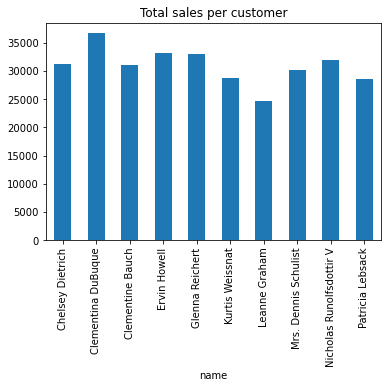

In [160]:
agg_1.plot(x="name", y=["total_amount"], kind="bar", title='Total sales per customer') 
plt.savefig("visualizations/total_sales_per_cust.jpg")

### Average order quantity per product

In [161]:
agg_2=merged_df.groupby(by=["product_id"])['quantity'].mean()
agg_2.to_sql(name='avg_qty_per_prod', if_exists='replace', con=RETAIL_COMPANY_DB)

50

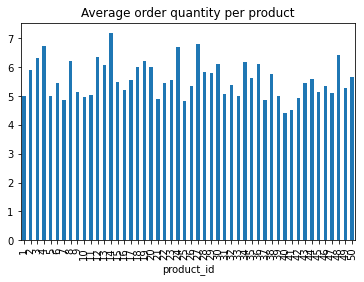

In [162]:
agg_2.plot(x="product_id", y=["quantity"], kind="bar", title='Average order quantity per product') 
plt.savefig("visualizations/avg_qty_per_prod.jpg")

### Top selling products

In [163]:
agg_3=merged_df.groupby(by=["product_id"])['quantity'].sum().sort_values(ascending=False)[:10]
agg_3.to_sql(name='top_selling_prods', if_exists='replace', con=RETAIL_COMPANY_DB)

10

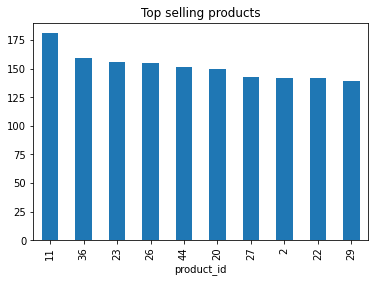

In [164]:
agg_3.plot(x="product_id", y=["quantity"], kind="bar", title='Top selling products') 
plt.savefig("visualizations/top_selling_prods.jpg")

In [165]:
merged_df['order_quarter'] = merged_df['order_date'].dt.year.astype('str') +'-'+ merged_df['order_date'].dt.quarter.astype('str')
merged_df['order_month'] = merged_df['order_date'].dt.year.astype('str') +'-'+ merged_df['order_date'].dt.month.astype('str')

### Quarterly sales

In [166]:
agg_4=merged_df.sort_values(by='order_quarter').groupby(by=["order_quarter"])['quantity'].sum()
agg_4.to_sql(name='quat_sales', if_exists='replace', con=RETAIL_COMPANY_DB)

5

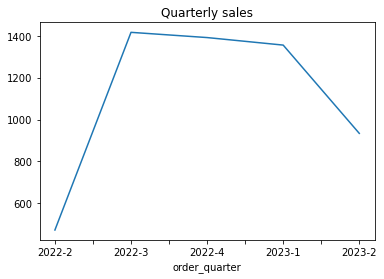

In [167]:
agg_4.plot(x="order_quarter", y=["quantity"], kind="line", title='Quarterly sales')
plt.savefig("visualizations/quat_sales.jpg")

### Monthly sales

In [168]:
agg_5=merged_df.sort_values(by='order_month').groupby(by=["order_month"])['quantity'].sum()
agg_5.to_sql(name='monthly_sales', if_exists='replace', con=RETAIL_COMPANY_DB)

13

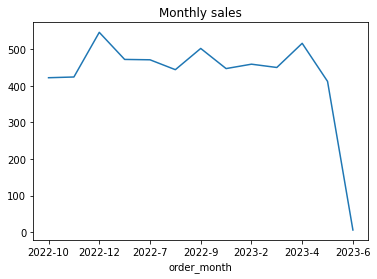

In [169]:
agg_5.plot(x="order_month", y=["quantity"], kind="line", title='Monthly sales')
plt.savefig("visualizations/monthly_sales.jpg")

### Average sales per weather condition

In [170]:
agg_6=merged_df.groupby(by=["weather"])['quantity'].mean()
agg_6.to_sql(name='avg_sales_per_weather', if_exists='replace', con=RETAIL_COMPANY_DB)

3

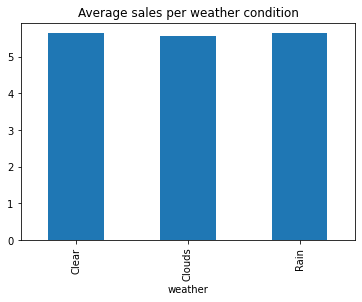

In [171]:
agg_6.plot(x="weather", y=["quantity"], kind="bar", title='Average sales per weather condition') 
plt.savefig("visualizations/avg_sales_per_weather.jpg")